In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFilter, ImageTransform
import random as rand
import os
import torch.nn.functional as F

#global variables to set size of image
X = 28
Y = 28

#color dictionary for image generation
COLOR = [
    'red', 'purple',
    'blue','yellow',
    'green', 'black'
]

#make a grey template image
img = np.zeros([X,Y,3],dtype=np.uint8)
img.fill(125) # numpy array!
im = Image.fromarray(img) #convert numpy array to image
im.save('blank.png')

# training images folder
try:
    os.makedirs("train_imgs")
    os.makedirs("train_imgs/rect")
    os.makedirs("train_imgs/tri")
    os.makedirs("train_imgs/circ")
except:
    print("Train folders already exist.")

# testing images folder
try:
    os.makedirs("test_imgs")
    os.makedirs("test_imgs/rect")
    os.makedirs("test_imgs/tri")
    os.makedirs("test_imgs/circ")
except:
    print("Test folders already exist.")

# validation images folder
try:
    os.makedirs("val_imgs")
    os.makedirs("val_imgs/rect")
    os.makedirs("val_imgs/tri")
    os.makedirs("val_imgs/circ")
except:
    print("Validation folders already exist.")

Train folders already exist.
Test folders already exist.
Validation folders already exist.


In [ ]:
def draw_rect(im):
    """
    Draw a square on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    #range of values for co-ordinates
    x_min = 0
    y_min = 0
    x_max = X - len
    y_max = Y - len
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    #randomly choose color
    c = rand.randint(0,5)
    draw.rectangle(
        [x,y,x+len,y+len],
        fill=COLOR[c]
    )
    return im

def draw_tri(im): 
    """
    Draw a triangle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    x_min = 0
    y_min = int(len/2)
    x_max = X-len
    y_max = Y
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    #randomly choose color
    c = rand.randint(0,5)
    draw.polygon(
        [(x,y),
            (int(x+len/2),int(y-len/2)),
            (x+len,y)], 
        fill = COLOR[c]
    )
    return im

def draw_circ(im): 
    """
    Draw a circle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    #bounding box for ellipse
    x_min = 0
    y_min = 0
    x_max = X - len
    y_max = Y - len
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    #randomly choose color
    c = rand.randint(0,5)
    draw.ellipse(
        [x,y,x+len,y+len],fill=COLOR[c]
        )
    return im

def make_image(num,shape,folder):
    """
    Given an number {num}
    and a shape type {shape}, draw that shape in a 
    random location in a 28x28 image and save it
    as "{shape}_{num}.png"
    """
    with Image.open("blank.png") as im:
        draw = ImageDraw.Draw(im)
        if shape=='rect':
            im = draw_rect(im)
        elif shape=='tri':
            im = draw_tri(im)
        elif shape=='circ':
            im = draw_circ(im)
        #blur the image 1/2 of the time
        if rand.randint(0,2) == 1:
            im = im.filter(filter=ImageFilter.BLUR)
        # save to png
        im.save(f"{folder}/{shape}/{num}.png")  
# make train and test images
for shape in ['rect','tri','circ']:
    for i in range(3000):
        make_image(i,shape,"train_imgs")
        make_image(i,shape,"test_imgs")
        make_image(i,shape,"val_imgs")
        
train_dataset = datasets.ImageFolder(root='train_imgs', transform = transforms.ToTensor())
train_loader = data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = datasets.ImageFolder(root='test_imgs', transform = transforms.ToTensor())
test_loader = data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

val_dataset = datasets.ImageFolder(root='val_imgs', transform = transforms.ToTensor())
val_loader = data.DataLoader(val_dataset, batch_size = 64, shuffle = True)

In [ ]:
# Get gpu device for training if available otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(1),
            nn.Linear(7744, 9)
        )

    def forward(self, x):
        x = self.CNN(x)
        output = F.log_softmax(x, dim=1)
        return output

model = NeuralNetwork().to(device)
print("Neural Network PyTorch Architecture:")
print(model)

#define loss function and optimizer
#cross entropy loss because we are doing binary classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Using cuda device
Neural Network PyTorch Architecture:
NeuralNetwork(
  (CNN): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=7744, out_features=3, bias=True)
  )
)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    history = []
    total_correct = 0
    total_done = 0
    count = 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        preds = model(x)
        loss = loss_fn(preds, y)

        # Backpropagation block
        # reset gradients to zero because by default we accumulate gradient 
        optimizer.zero_grad()
        # compute gradient of loss function using backprop
        loss.backward()
        # update parameters based on calculated gradient
        optimizer.step()

        # calculate accuracy 
        guesses = torch.argmax(preds, dim=1)
        correct = torch.sum(guesses==y).item()
        done = guesses.shape[0]
        total_correct += correct
        total_done += done

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(x)
            history.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        count += 1

    #average accuracy over training set during training
    acc = total_correct / total_done
    return acc, history
    
def test_acc(dataloader, model, loss_fn):
    """
    Compute loss and accuracy of a model on some data
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_done = 0
    total_correct = 0
    test_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            # We compute this prediction loss
            loss = loss_fn(pred, y)
            guesses = torch.argmax(pred, dim=1)
            correct = torch.sum(guesses==y).item()
            done = guesses.shape[0]
            total_correct += correct
            total_done += done
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    acc = total_correct / total_done
    return acc, test_loss

# Train and plot history (from a2)

Epoch 1
-------------------------------
loss: 1.101023  [    0/ 9000]
loss: 1.065745  [ 3200/ 9000]
loss: 0.839961  [ 6400/ 9000]
Epoch 2
-------------------------------
loss: 0.638511  [    0/ 9000]
loss: 0.492208  [ 3200/ 9000]
loss: 0.461983  [ 6400/ 9000]
Epoch 3
-------------------------------
loss: 0.378754  [    0/ 9000]
loss: 0.234779  [ 3200/ 9000]
loss: 0.244975  [ 6400/ 9000]
Epoch 4
-------------------------------
loss: 0.266295  [    0/ 9000]
loss: 0.269938  [ 3200/ 9000]
loss: 0.212951  [ 6400/ 9000]
Epoch 5
-------------------------------
loss: 0.118621  [    0/ 9000]
loss: 0.081463  [ 3200/ 9000]
loss: 0.133280  [ 6400/ 9000]
Epoch 6
-------------------------------
loss: 0.159094  [    0/ 9000]
loss: 0.071365  [ 3200/ 9000]
loss: 0.131465  [ 6400/ 9000]
Epoch 7
-------------------------------
loss: 0.079905  [    0/ 9000]
loss: 0.101692  [ 3200/ 9000]
loss: 0.110706  [ 6400/ 9000]
Epoch 8
-------------------------------
loss: 0.119310  [    0/ 9000]
loss: 0.086281  [ 32

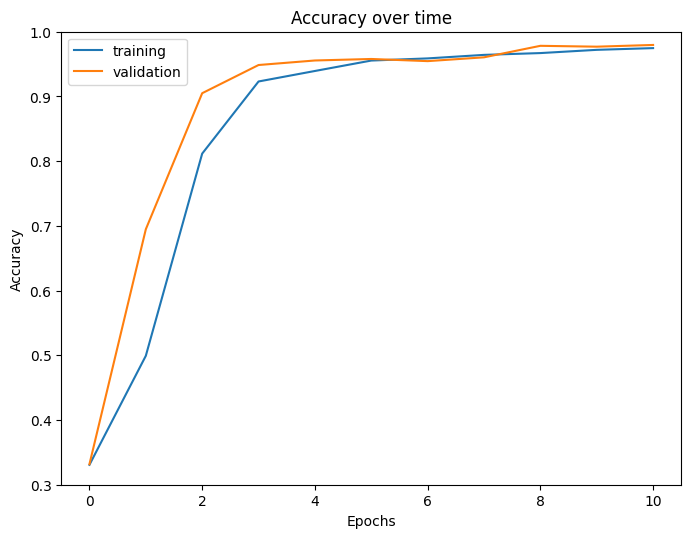

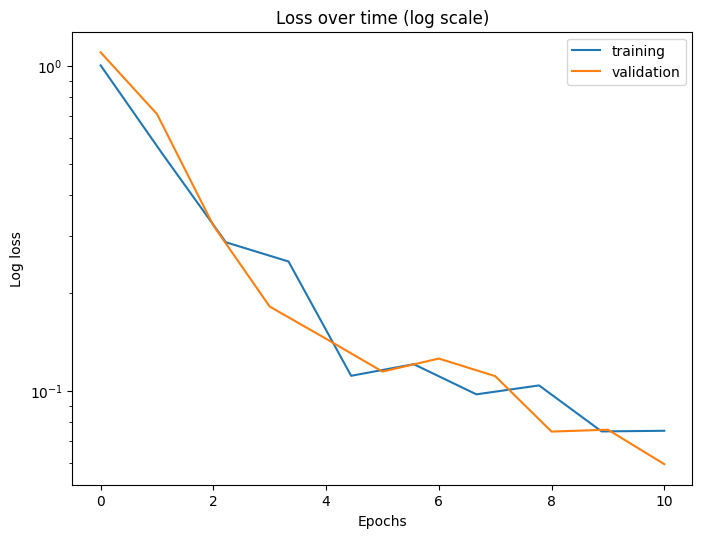

In [ ]:
"""
Train the model
Store training and validation loss and accuracy along the way
"""
epochs = 15
train_accs = []
train_losses = []
val_accs = []
val_losses = []
#initial val loss
val_acc, val_loss = test_acc(val_loader, model, loss_fn)
val_accs.append(val_acc)
val_losses.append(val_loss)
#initial training loss
train_acc, train_loss = test_acc(train_loader, model, loss_fn)
train_accs.append(train_acc)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_acc, t_loss = train(train_loader, model, loss_fn, optimizer)
    #t_acc, t_loss = test_acc(train_loader, model, loss_fn)
    train_accs.append(t_acc)
    train_losses.append(t_loss)
    v_acc, v_loss = test_acc(val_loader, model, loss_fn)
    val_accs.append(v_acc)
    val_losses.append(v_loss)
print("Done!")

# PLOT ACCURACIES
train_accs = np.ravel(np.asarray(train_accs))
val_accs = np.reshape(val_accs,-1)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, num=len(train_accs))
x_v = np.linspace(0, epochs, num=len(val_accs))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, train_accs,label="training")
plt.plot(x_v, val_accs,label="validation")
plt.yscale("linear")
plt.title("Accuracy over time")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('acc.png')
plt.ylim([0.3,1])
plt.show()

# PLOT LOSS
t_losses_final = np.ravel(np.mean(train_losses,axis=1))
#t_losses_final = np.ravel(train_losses)
val_losses_final = np.ravel(val_losses)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, len(t_losses_final))
x_v = np.linspace(0, epochs, len(val_losses_final))
fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, t_losses_final,label="training")
plt.plot(x_v, val_losses_final,label="validation")
plt.yscale("log")
plt.title("Loss over time (log scale)")
plt.ylabel("Log loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('log_loss.png')
plt.show()

In [ ]:
"""
Given a build of the model, calculate test loss
"""
#test accuracy needs to be run with batch_size=1
test_accuracy = test_acc(test_loader, model, loss_fn)
print("Accuracy: ", test_accuracy[0])

Accuracy:  0.9927777777777778


# a3 code for training and plotting guesses

In [ ]:
epochs = 15
hists = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    hist = train(train_loader, model, loss_fn, optimizer)
    hists.append(hist)
print("Done!")
train_res = test_acc(train_loader, model, loss_fn)
test_res = test_acc(test_loader, model, loss_fn)
print("~"*50)
print(f"Accuracy on train dataset: {train_res[0]}")
print(f"Test loss on train dataset: {train_res[1]}")
print("~"*50)
print(f"Accuracy on test dataset: {test_res[0]}")
print(f"Test loss on test dataset: {test_res[1]}")

Epoch 1
-------------------------------
loss: 0.074258  [    0/ 9000]
loss: 0.042071  [ 3200/ 9000]
loss: 0.029328  [ 6400/ 9000]
Epoch 2
-------------------------------
loss: 0.032055  [    0/ 9000]
loss: 0.099007  [ 3200/ 9000]
loss: 0.071224  [ 6400/ 9000]
Epoch 3
-------------------------------
loss: 0.083957  [    0/ 9000]
loss: 0.031315  [ 3200/ 9000]
loss: 0.064086  [ 6400/ 9000]
Epoch 4
-------------------------------
loss: 0.029281  [    0/ 9000]
loss: 0.031869  [ 3200/ 9000]
loss: 0.024548  [ 6400/ 9000]
Epoch 5
-------------------------------
loss: 0.024420  [    0/ 9000]
loss: 0.106408  [ 3200/ 9000]
loss: 0.019684  [ 6400/ 9000]
Epoch 6
-------------------------------
loss: 0.050265  [    0/ 9000]
loss: 0.021522  [ 3200/ 9000]
loss: 0.021497  [ 6400/ 9000]
Epoch 7
-------------------------------
loss: 0.032519  [    0/ 9000]
loss: 0.018848  [ 3200/ 9000]
loss: 0.028867  [ 6400/ 9000]
Epoch 8
-------------------------------
loss: 0.062999  [    0/ 9000]
loss: 0.062555  [ 32

# Plot some guesses

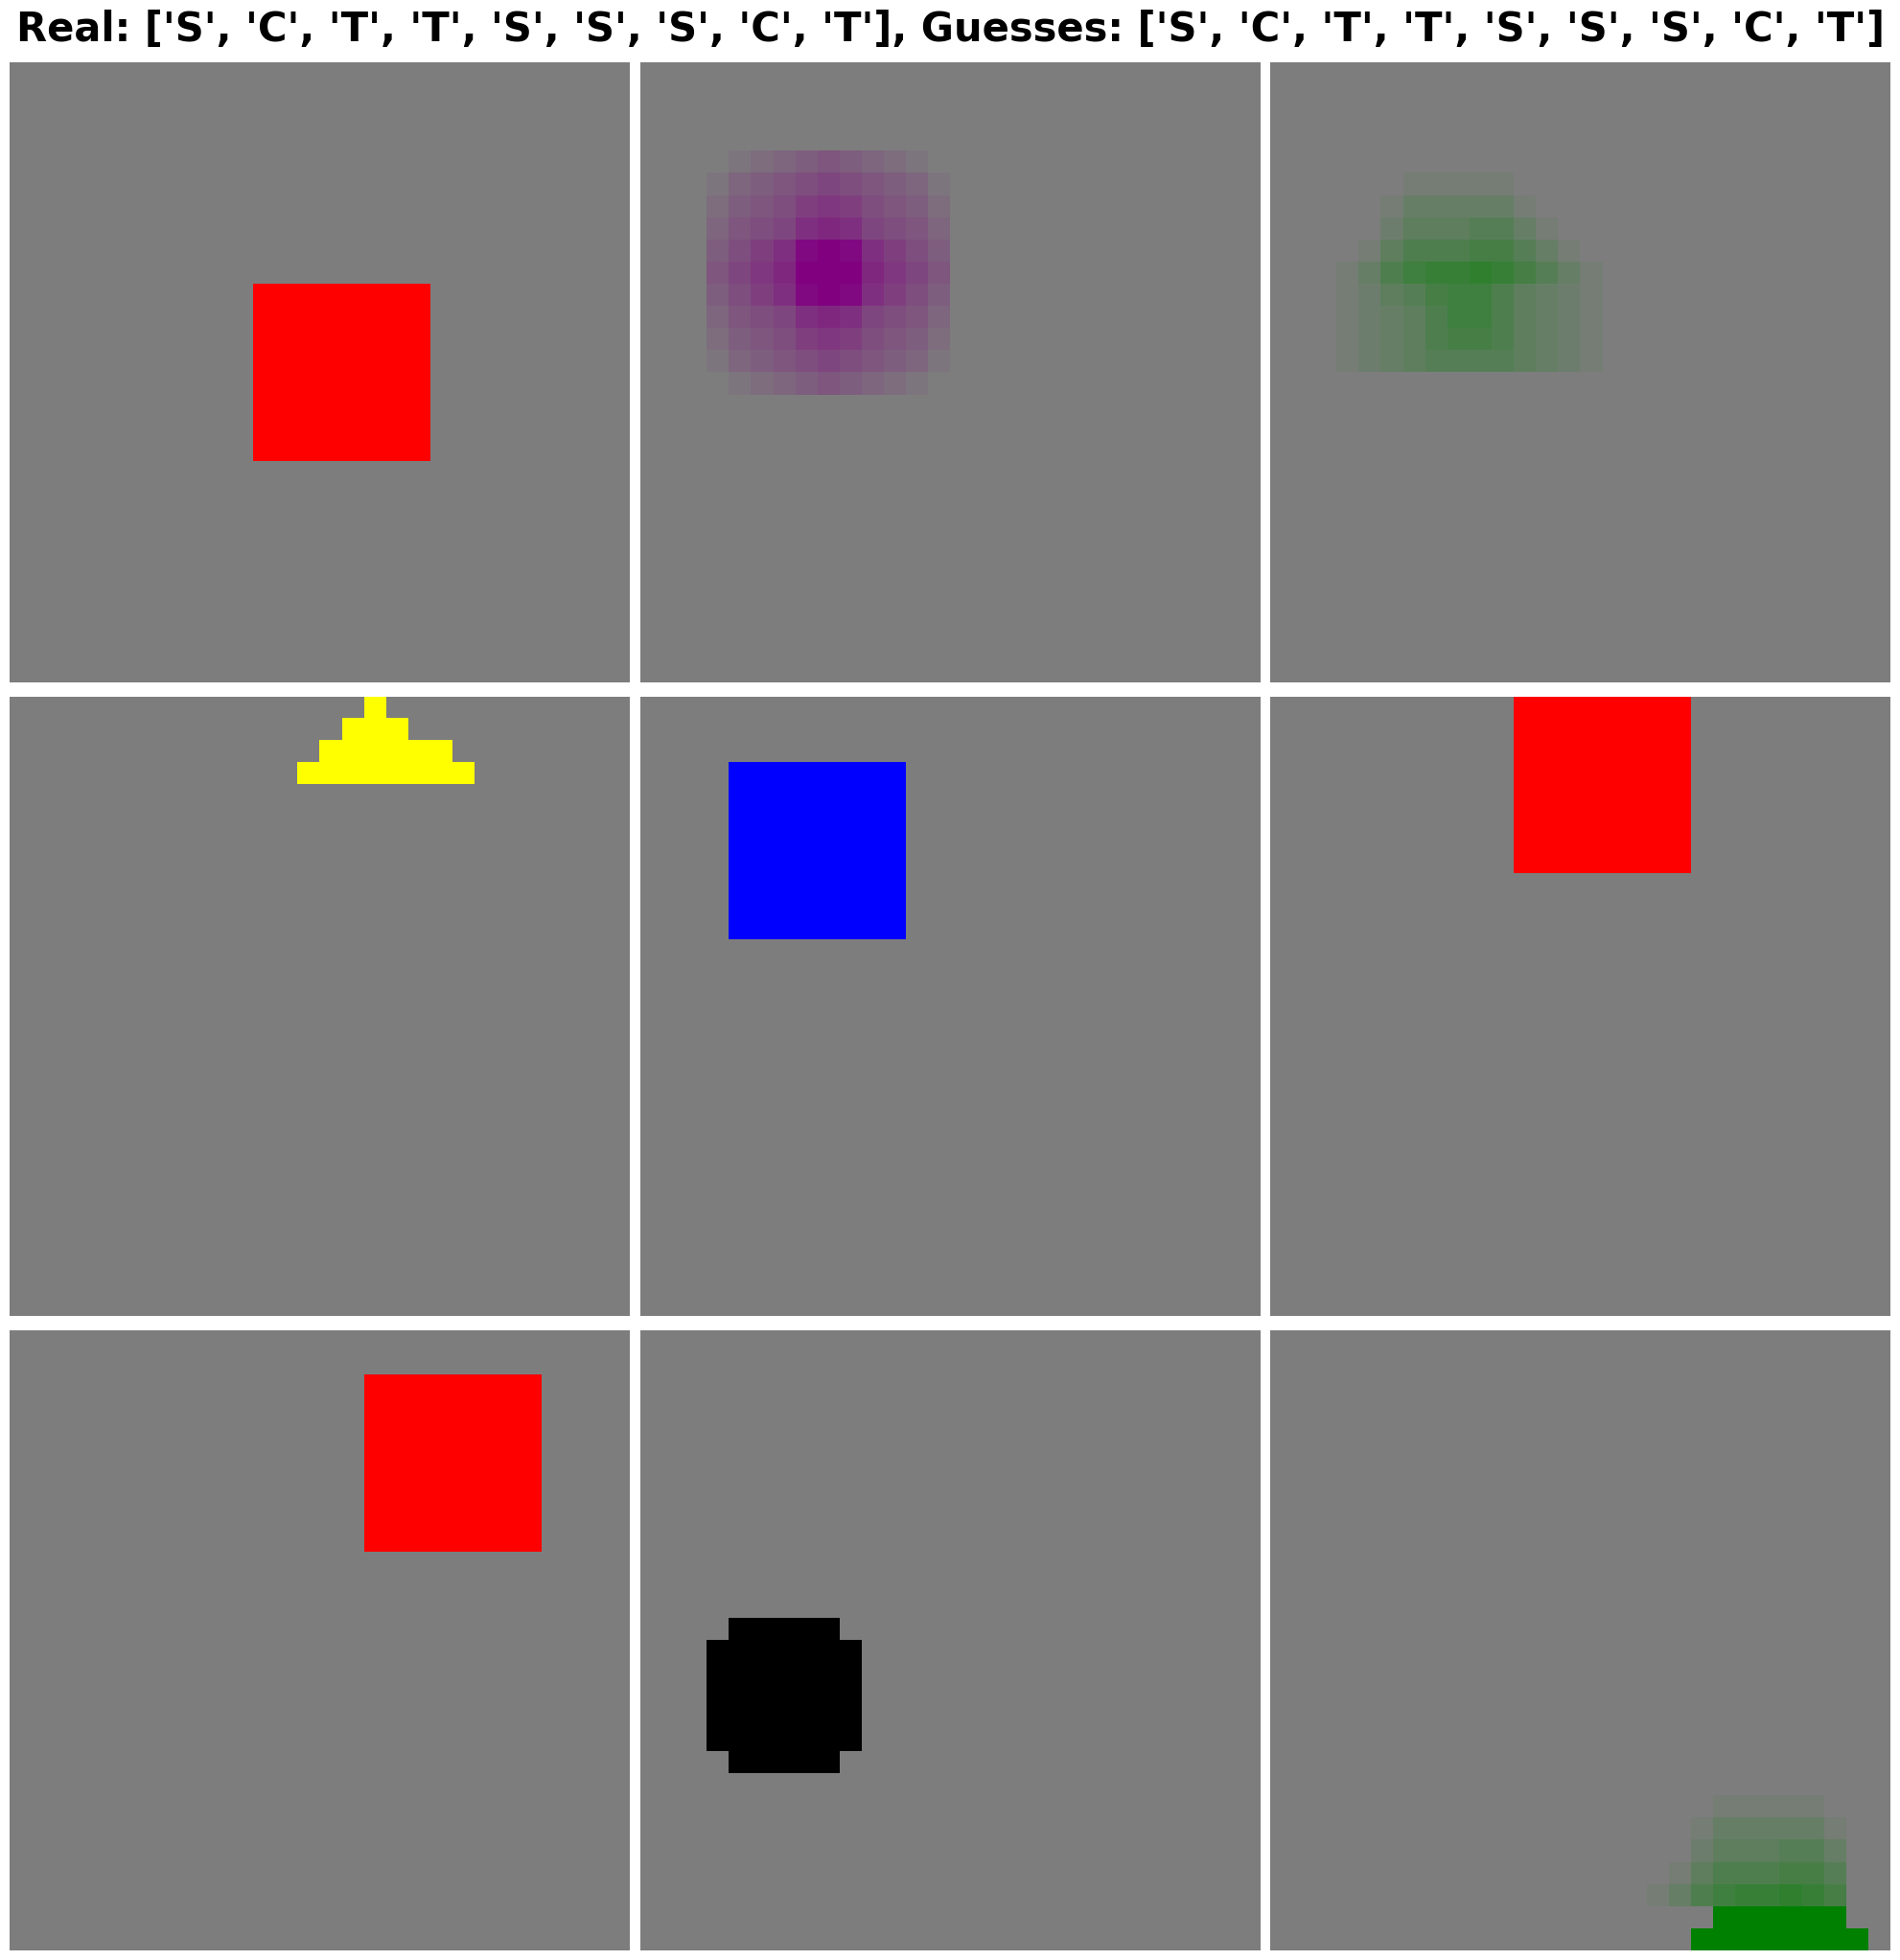

In [ ]:
# redo with batch size = 1 for easy plotting
test_dataset = datasets.ImageFolder(root='test_imgs', transform = transforms.ToTensor())
test_loader = data.DataLoader(test_dataset, batch_size = 1, shuffle = True)
# Plot some guesses
shapes = {"0":"C", "1":"S", "2":"T"}

size=3

guesses = []
actual = []
cords=[
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],[2,1],[2,2]
]

fig, ax_arr = plt.subplots(size, size, figsize=(20, 20), dpi=100)

for batch, (x, y) in enumerate(test_loader):
    truth = f"{y.item()}"
    grid_spot = cords[batch]
    ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
    ax_cur.imshow(torch.squeeze(x).permute(1,2,0))
    ax_cur.axis('off')
    #our pred_dist is a weighting of how much it thinks each rotation is likely, 3 long
    pred_dist = model(x.to(device))
    #grab the index of the maximum argument as our guess
    guess = str(torch.argmax(pred_dist).item())
    guesses.append(shapes[guess])
    actual.append(shapes[truth])
    #ax_cur.set_title(f"shape {shapes[truth]}, guessed {shapes[guess]}")
    if batch == (size*size-1):
        break

fig.suptitle(
    f"Real: {actual}, Guesses: {guesses}",
    size=30,
    y=1.02,
    weight='bold'
)

plt.axis('off')
plt.tight_layout()
plt.savefig(
    'guesses.png',
    bbox_inches='tight'
)